# Detect tomatoes & Extract ROI

In [1]:
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow

def load_img(path=None, blur_size=(5,5), inverse=False, threshold_val=100, min_area=1000):
    img = cv.imread(path, cv.IMREAD_COLOR)
    if img is None:
        print('Can\'t find the image')
        return 0

    scale_percent = int(360/img.shape[0]*100)
    new_width = img.shape[1]*scale_percent//100
    new_height = img.shape[0]*scale_percent//100
    img = cv.resize(img, (new_width, new_height), interpolation=cv.INTER_AREA)
    # drew_img = img     #### đây là reference, không phải clone
    drew_img = np.copy(img)
    
    blur_img = cv.GaussianBlur(img, blur_size, 0)
    # giảm nhiễu, bớt sắc cạnh của lá

    gray_img = cv.cvtColor(blur_img, cv.COLOR_BGR2GRAY)
    # pixel intensity < 100 => 0 else 1
    
    ret, bin_otsu_img = cv.threshold(gray_img, threshold_val, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    # Otsu tự tính ra ngưỡng
    if inverse is True:
        bin_otsu_img = cv.bitwise_not(bin_otsu_img)
        # bin_otsu_img = ~bin_otsu_img   # đảo bit  ---> phần quả biến thành màu đen, ko đảo: phần quả biến thành màu trắng
    bin_otsu_img_before = np.copy(bin_otsu_img)
    ################### BINARY PHẦN QUẢ PHẢI MÀU TRẮNG THÌ MỚI LÀM VIỆC TIẾP ĐƯỢC
    
    #################### OPEN
    # ele = cv.getStructuringElement(shape=cv.MORPH_RECT, ksize=(5,5), anchor=(-1, -1))  # anchor=(-1,-1) mean center
    # bin_otsu_img = cv.morphologyEx(bin_otsu_img, cv.MORPH_OPEN, ele)
    # cv.imshow("bin otsu after", bin_otsu_img)

    #################### ERODE (=BIG KER) THEN DILATE (=SMALL KER)
    ele = cv.getStructuringElement(shape=cv.MORPH_RECT, ksize=(15,15), anchor=(-1, -1))  # anchor=(-1,-1) mean center
    bin_otsu_img = cv.morphologyEx(bin_otsu_img, cv.MORPH_ERODE, ele)
    ele = cv.getStructuringElement(shape=cv.MORPH_RECT, ksize=(11,11), anchor=(-1, -1))  # anchor=(-1,-1) mean center
    bin_otsu_img = cv.morphologyEx(bin_otsu_img, cv.MORPH_DILATE, ele)


    contour_list, hierachy = cv.findContours(bin_otsu_img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    print("number of contours: ", len(contour_list))

    roi_list = []
    for i, c in enumerate(contour_list):
        x,y,w,h = cv.boundingRect(c)
        print("{}:\t x={}, y={}, w={}, h={}".format(i,x,y,w,h))   # in ra thông tin của mọi contour
        # if )  and (cv.contourArea(c) > min_area or w*h>min_area): # loại bỏ các hình chữ nhật dài quá
        if (cv.contourArea(c) > min_area or w*h>min_area) and min(w,h) > 50  and max(w,h)/min(w,h) < 5 :
            x = max(0, x - int(w*0.2))
            y = max(0, y - int(h*0.2))
            w = int(w*1.3)
            h = int(h*1.3)
            roi_list.append((i,x,y,w,h))
            # cv.rectangle(drew_img,(x,y),(x+w,y+h),(0,255,0),2)
            cv.rectangle(drew_img,(x,y),(x+max(w,h),y+max(w,h)),(0,255,0),2)
            cv.putText(drew_img, str(i), (x+w//2, y+h//2), cv.FONT_HERSHEY_COMPLEX, 1, (255,255,255), 2, cv.LINE_AA, )
        drew_img = cv.drawContours(drew_img, [c], -1, (255,0,0), 3)                     # -1: draw all, else: draw contour_list[i]

            # epsilon = 0.05*cv.arcLength(c,True)
            # approx = cv.approxPolyDP(c,epsilon,True)  # also a contour    # xẩp xỉ contour thành hình đa giác
            # drew_img = cv.drawContours(drew_img, [approx], -1, (0,255,0), 3)
    return img, roi_list

path = r'/content/drive/MyDrive/ripe_fruit/sample-not-ok-1.jpg' 

img, roi_list = load_img(path,
    blur_size=(5,5),
    inverse=False,
    threshold_val=115,    # phần quả trong binary ít quá ---> phải tăng ngưỡng sáng lên
    min_area=1500)

print("ROI bound rectangles:")
roi_img_list = []
for i,a in enumerate(roi_list):
    (i,x,y,w,h) = a
    print("{}:\t x={}, y={}, w={}, h={}".format(i,x,y,w,h))
    small_img = img[y:y+max(h,w), x:x+max(h,w)]
    roi_img_list.append(small_img)



number of contours:  9
0:	 x=449, y=339, w=13, h=13
1:	 x=509, y=337, w=13, h=15
2:	 x=472, y=273, w=50, h=34
3:	 x=472, y=173, w=50, h=70
4:	 x=487, y=94, w=35, h=53
5:	 x=488, y=0, w=34, h=62
6:	 x=98, y=0, w=383, h=352
7:	 x=0, y=0, w=160, h=290
8:	 x=0, y=0, w=21, h=21
ROI bound rectangles:
6:	 x=22, y=0, w=497, h=457
7:	 x=0, y=0, w=208, h=377


# Preprocessing and extract feature

In [2]:
# Import những thứ cơ bản ở trên cùng
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt

__target_size = (224,224)

from tensorflow.keras.applications import imagenet_utils
preprocessed_roi = []
for (i, roi) in enumerate(roi_img_list):
    roi = cv.cvtColor(roi, cv.COLOR_BGR2RGB)
    # roi = roi/255.0
    roi = cv.resize(roi, __target_size, interpolation=cv.INTER_AREA)
    roi = np.expand_dims(roi, 0)
    roi = imagenet_utils.preprocess_input(roi)
    preprocessed_roi.append(roi)



In [3]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model

pretrained_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
)
pretrained_model.summary()

x = pretrained_model.get_layer('block5_pool').output
# x = GlobalAveragePooling2D()(x)
# x = Flatten()(x)

feature_extractor = Model(inputs=pretrained_model.input,
                          outputs = x)
mlp_model = tf.keras.models.load_model("/content/drive/MyDrive/ripe_fruit/vgg16-mlp-15-12.h5")

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

[1.8392853e-26 1.0000000e+00 0.0000000e+00] -----> ripe
[2.349093e-25 1.000000e+00 0.000000e+00] -----> ripe


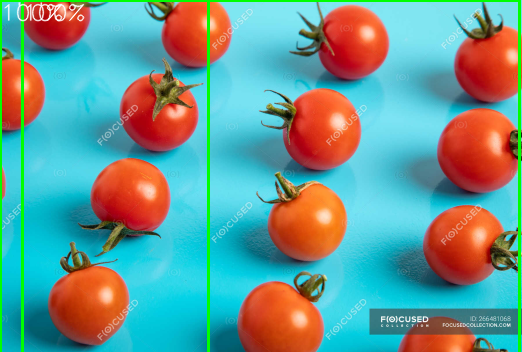

In [4]:
class_name = ['partly_ripe','ripe','unripe',]
drew_img = np.copy(img)
for i, roi in enumerate(preprocessed_roi):
    fmap = pretrained_model.predict(roi)
    predict = mlp_model.predict(fmap)[0]
    print(predict, '----->', class_name[np.argmax(predict)])
    (ind,x,y,w,h) = roi_list[i]
    cv.putText(drew_img, 
               class_name[np.argmax(predict)], 
               (x,y),
               cv.FONT_HERSHEY_SIMPLEX, 
               0.75, (255,255,255), 
               1, cv.LINE_AA)
    cv.putText(drew_img, 
               str(int(max(predict)*100)) + "%", 
               (x,y+20),
               cv.FONT_HERSHEY_SIMPLEX, 
               0.75, (255,255,255), 
               1, cv.LINE_AA)
    cv.rectangle(drew_img,(x,y),(x+w,y+h),(0,255,0),2)
cv2_imshow(drew_img)

In [5]:
img.shape

(352, 522, 3)